# Unit 2 Portfolio Project
## Predictive Modeling with Spotify Data
Ryan Fikejs - *Data Science, Lambda School DS 26*

### Build Week Day 1 (v2.0)

*Use Pandas Profiling to get a bigger picture of what we're dealing with*



*Make a linear model for comparison.*



*Do some hyper parameter tuning*



*Engineer an 'age' feature, or test with 'realease_date' back intact*



*Process oridnally encode artists id column such that Shaply force plot will work*



Notes:

• v2.0.1 uses only songs which are highly danceable

• 

• 

### Module 4 Tasks (v1.3)

*Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.*



*Make at least 1 partial dependence plot to explain your model.*



*Make at least 1 Shapley force plot to explain an individual prediction.*



*Share at least 1 visualization (of any type) on Slack!*



Notes:

• Trimmed data set down to the past 50 years

• Hypertuned some parameters

• Dropped some columns for minimal impact on target as informed by 
the permutation importances

### Module 3 Tasks (v1.2)

*Continue to clean and explore your data. Make exploratory visualizations*



*Fit a model. Does it beat your baseline?*

Yes.

*Try XGBoost*

Didn't perform as well on first run, but I will take out some features and do some more tuning.

*Get your model's permutation importances.*


**Notes:**

• Added <inplace=True> to the part of the wrangle function dropping 'popularity' feature 

• Considering looking at releases from the past 20 - 50 years as I think that would still be a relevant set of data to learn from.

### Module 2 Tasks (v1.1)

*Continue to clean and explore your data.*

Data is very clean, but I did decide on a few columns to create and drop.

*For the evaluation metric you chose, what score would you get just by guessing?*

For this afternoon I just went ahead with the accuracy score, but tonight I will experiment with others.

*Can you make a fast, first model that beats guessing?*

I did, but it may be too good. Further investigating tonight


**Notes:**

• I did change my target array to five classes / buckets (100+ is too many for what I'm trying to do)

• I may change my target to a binary classification

• I may consider trying to do this task for a more specific genre in order to work with a smaller data set.

### Module 1 Tasks

*Choose your target. Which column in your tabular dataset will you predict?*

My target is the popularity rating.

*Is your problem regression or classification?*

Currently considering it a large scale classification problem, (there are 101 classes involved) wondering if I should cut it down as was done in the burrito problem and say a popularity rating of 80-100 is very popular, below 80 is not very popular.

*How is your target distributed?*

*Classification: How many classes? Are the classes imbalanced?*

101 classes very imbalanced.

*Choose your evaluation metric(s).*

*Classification: Is your majority class frequency >= 50% and < 70% ? If so, you can just use accuracy if you want. Outside that 
range, accuracy could be misleading. What evaluation metric will you choose, in addition to or instead of accuracy?*

No, I will likely be using F1-score and AUC of ROC. (Maybe categorical crossentropy if I learn enough about it and it makes sense to, I heard it's good for generalizing multiclass problems, but is typically used with neural networks.)

*Choose which observations you will use to train, validate, and test your model.*

I will use a random selection via train test split to separate atraining set and cross validation for training and validation.

*Are some observations outliers? Will you exclude them?*

No

*Will you do a random split or a time-based split?*

Random split

*Begin to clean and explore your data.*

*Begin to choose which features, if any, to exclude. Would some features "leak" future information?*

I will leave out song ID and name. I may keep either artists or id_artists.

## I. Wrangle Data

### Import packages

In [2]:
# For data frame manipulation
import pandas as pd

# For more math horsepower
import numpy as np

# For plotting
import matplotlib.pyplot as plt

# For exploratory data analysis / profiling
from pandas_profiling import ProfileReport

# For pipeline and model building
# Pipeline
from sklearn.pipeline import make_pipeline
# Transformers
from category_encoders import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
# For random forest
from sklearn.ensemble import RandomForestClassifier
# For gradient boost
from xgboost import XGBClassifier
# For splitting data, scoring, tuning
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV

# For scoring and evaluating results
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report
# For determining most important features
from sklearn.inspection import permutation_importance

# For demostrating partial dependencies of the target on
# specific features 
from pdpbox.pdp import pdp_isolate, pdp_interact, pdp_plot, pdp_interact_plot 

# For displaying a Shaply force plot
import shap

## Wrangle Data

In [10]:
def wrangle(file_path):
    df = pd.read_csv(file_path,
                    parse_dates=['release_date'])
    
    # Split release_date into day, month, year, then drop it
    df['released_year'] = df['release_date'].dt.year
    df['released_month'] = df['release_date'].dt.month
    df['released_day'] = df['release_date'].dt.day
    df.drop(columns=['release_date'], inplace=True)
    
    # Make new buckets for prediction
    df['popular'] = [0 if r<19 else 1 if r<39 else 2 if r<59 else 3 if r<79 else 4 for r in df['popularity']]
    df.drop(columns='popularity', inplace=True)
    
    # Drop columns I suspect do not imfluence the target, or are redundant
    df.drop(columns=['id', 'name', 'artists'], inplace=True)
    
    # Limit the data set to the past 50 years
    df = df[df['released_year'] >= 1971]
    
    # Drop columns that were determined to have least importance
    # in my permutation importances below
    df.drop(columns=['key', 'time_signature', 'mode', 'tempo',
                     'valence', 'liveness', 'released_day',
                     'speechiness', 'explicit'],
                    inplace=True)
    
    return df

In [11]:
df = wrangle('data/tracks.csv')

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 459751 entries, 39501 to 586671
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   duration_ms       459751 non-null  int64  
 1   id_artists        459751 non-null  object 
 2   danceability      459751 non-null  float64
 3   energy            459751 non-null  float64
 4   loudness          459751 non-null  float64
 5   acousticness      459751 non-null  float64
 6   instrumentalness  459751 non-null  float64
 7   released_year     459751 non-null  int64  
 8   released_month    459751 non-null  int64  
 9   popular           459751 non-null  int64  
dtypes: float64(5), int64(4), object(1)
memory usage: 38.6+ MB


In [14]:
df_dance = df[df['danceability'] >= 0.9].copy()

In [15]:
df_dance.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4748 entries, 44840 to 586632
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   duration_ms       4748 non-null   int64  
 1   id_artists        4748 non-null   object 
 2   danceability      4748 non-null   float64
 3   energy            4748 non-null   float64
 4   loudness          4748 non-null   float64
 5   acousticness      4748 non-null   float64
 6   instrumentalness  4748 non-null   float64
 7   released_year     4748 non-null   int64  
 8   released_month    4748 non-null   int64  
 9   popular           4748 non-null   int64  
dtypes: float64(5), int64(4), object(1)
memory usage: 408.0+ KB


2    1937
1    1508
3     689
0     574
4      40
Name: popular, dtype: int64


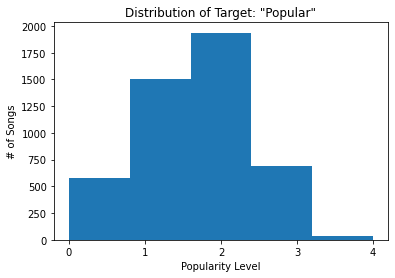

In [16]:
# Look at the distribution of the target
class_dist = df_dance['popular']
print(class_dist.value_counts())
plt.hist(class_dist, bins=5)
plt.xticks((0, 1, 2, 3, 4))
plt.xlabel('Popularity Level')
plt.ylabel('# of Songs')
plt.title('Distribution of Target: "Popular"')
plt.show()

In [18]:
# Get a view of the cardinality of features
df_dance.nunique()

duration_ms         4192
id_artists          3063
danceability          90
energy               802
loudness            3781
acousticness        1735
instrumentalness    1944
released_year         51
released_month        12
popular                5
dtype: int64

### Exploratory Data Analysis

In [19]:
# Create a Pandas Profile Report for the data
pan_pro = ProfileReport(df_dance)
pan_pro

Summarize dataset:   0%|          | 0/24 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

## Split Data

In [23]:
# Establish the target and split the data accordingly
target = 'popular'
X_ = df_dance.drop(columns=target)
y_ = df_dance[target]

In [24]:
# Split the data into training and testing sets
X, X_test, y, y_test = train_test_split(X_, y_, train_size=0.8, random_state=73)

# Further split training set into training and 
# validation for initial model
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=37)

## Establish a Baseline

In [25]:
baseline = y.value_counts(normalize=True).max()
print(f'Baseline: {baseline}')

Baseline: 0.4073196419167983


In [12]:
# Consider establishing an alternate basline?

## Build a Model

### Random Forest (bagging model)

In [26]:
# Make a model using a random forest
model_rf = make_pipeline(
            OrdinalEncoder(),
            StandardScaler(),
            RandomForestClassifier(random_state=37, n_jobs=-2))

# Fit the random forest model
model_rf.fit(X_train, y_train)

Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['id_artists'],
                                mapping=[{'col': 'id_artists',
                                          'data_type': dtype('O'),
                                          'mapping': ['4o4tLTIJ3eWMFerz73atcT']                                 1
['1dqCEoBppk9X0WmOTJe993']                                 2
['7jLOrU2XbkSEDJL26be4Mr']                                 3
['2NdeV5rLm47xAvogXrYhJX', '6vdMPayKk8YJxxeNP5oMCb']       4
['1gRr6moof50L1b7XsbClvI']                                 5
                                                        ... 
['7ufLkxlHrq3NRaS1fCHOgq']                              2155
['2e7yDxnK4osy7nKhnqrOFM']                              2156
['6GRC8segVAr34gm6pjfSoQ']                              2157
['7DXgHMWLJlH6uFTaDKk0Zv']                              2158
NaN                                                       -2
Length: 2159, dtype: int64}])),
                ('standard

### XGBoost (boosting model)

In [27]:
# Make a boosted model
model_xgb = make_pipeline(
    OrdinalEncoder(),
    StandardScaler(),
    XGBClassifier(n_estimators=36, random_state=73, n_jobs=-2)
)

# Fit the boosted model
model_xgb.fit(X_train, y_train)

[13:34:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['id_artists'],
                                mapping=[{'col': 'id_artists',
                                          'data_type': dtype('O'),
                                          'mapping': ['4o4tLTIJ3eWMFerz73atcT']                                 1
['1dqCEoBppk9X0WmOTJe993']                                 2
['7jLOrU2XbkSEDJL26be4Mr']                                 3
['2NdeV5rLm47xAvogXrYhJX', '6vdMPayKk8YJxxeNP5oMCb']       4
['1gRr6moof50L1b7XsbClvI']                                 5
                                                        ... 
['7ufLkxlHrq3NRaS1fCHOgq']                              2155
['2e7yDxnK4osy7nKhnqrOFM']...
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
     

## Check Metrics

In [28]:
# Accuracy scores for random forest model
print(accuracy_score(y_train, model_rf.predict(X_train)))
print(accuracy_score(y_val, model_rf.predict(X_val)))

0.9967083607636603
0.5184210526315789


In [29]:
# Accuracy scores for gradient boost model
print(accuracy_score(y_train, model_xgb.predict(X_train)))
print(accuracy_score(y_val, model_xgb.predict(X_val)))

0.8976300197498355
0.46578947368421053


In [47]:
print(classification_report(y_val, model_rf.predict(X_val)))

              precision    recall  f1-score   support

           0       0.61      0.41      0.49     16207
           1       0.56      0.73      0.63     31475
           2       0.52      0.48      0.50     20996
           3       0.46      0.16      0.24      4679
           4       0.19      0.02      0.04       203

    accuracy                           0.55     73560
   macro avg       0.47      0.36      0.38     73560
weighted avg       0.55      0.55      0.54     73560



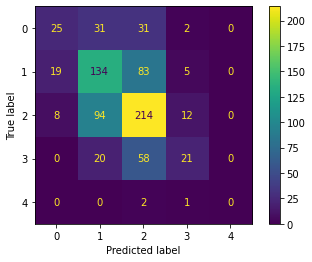

In [30]:
# Confusion Matrix for random forest base model
rf_val_cmatrix = plot_confusion_matrix(model_rf, X_val, y_val,)
rf_val_cmatrix;

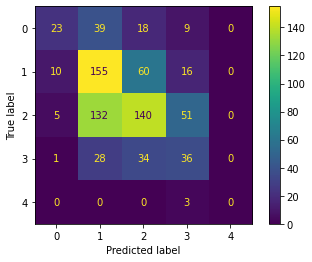

In [31]:
# Confusion Matrix for gradient boost base model
xgb_val_cmatrix = plot_confusion_matrix(model_xgb, X_val, y_val,)
xgb_val_cmatrix;

## Tune Model

### Permutation Importances (to negate features in wrangle)

In [32]:
# Calculate permutation importances
perm_imp = permutation_importance(
    model_xgb,
    X_val,
    y_val,
    n_repeats=8,
    n_jobs=-2,
    random_state=41)

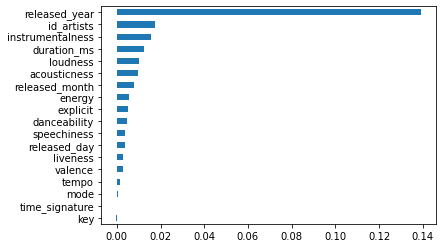

In [25]:
# # Plot the permutation importances

# # Create a data frame of the importances and feature names
# data = {'imp_mean': perm_imp['importances_mean'],
#         'imp_std': perm_imp['importances_std']}
# imp_df = pd.DataFrame(data, index=X_val.columns).sort_values('imp_mean')

# # Plot a bar chart
# imp_df['imp_mean'].plot(kind='barh');

In [33]:
# # Create a list of least important features to drop in
# # the wrangle function (copy and paste the list)
# imp_df[imp_df['imp_mean'] < 0.005].index

Index(['key', 'time_signature', 'mode', 'tempo', 'valence', 'liveness',
       'released_day', 'speechiness', 'danceability', 'explicit'],
      dtype='object')

### Permutation Importances (after trimming data set)

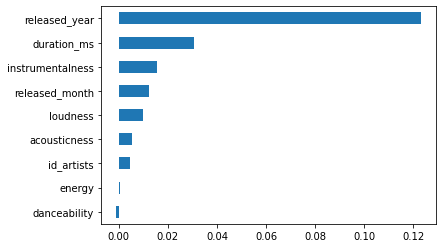

In [33]:
# Plot the permutation importances

# Create a data frame of the importances and feature names
data = {'imp_mean': perm_imp['importances_mean'],
        'imp_std': perm_imp['importances_std']}
imp_df = pd.DataFrame(data, index=X_val.columns).sort_values('imp_mean')

# Plot a bar chart
imp_df['imp_mean'].plot(kind='barh');

### Hyper parameter tuning

In [ ]:
# Do a randomized search to start the tuning process

# Setup empty results list
results = []

# Recall the pipeline(s)
model_xgb_ = make_pipeline(
    OrdinalEncoder(),
    StandardScaler(),
    XGBClassifier(random_state=73)
)

# Set a dictionary of the parameters to test
params = {
    'xgbclassifier__max_depth': np.arange(14, 40, 2),
    'xgbclassifier__n_estimators': np.arange(25, 150, 5),
    'xgbclassifier__learning_rate': np.arange(0.01, 0.11, 0.01),
    'xgbclassifier__gamma': np.arange(0.0, 1.1, 0.1),
    'xgbclassifier__reg_alpha': np.arange(0.0, 1.1, 0.1),
}

# Instatiate a RandomizedSearchCV model 
model_rs = RandomizedSearchCV(model_xgb_, params, n_iter=5, n_jobs=-2, verbose=3)

# Store some results to choose from and then run through the model at the top
model_rs.fit(X_train, y_train)
val_acc = accuracy_score(y_val, model_rs.predict(X_val))
results.append((model_rs.best_params_, val_acc))

# Compare results
print(model_rs.best_params_, val_acc)
results

Fitting 5 folds for each of 5 candidates, totalling 25 fits


## Communicate Results

I didn't realize that for a classification problem the pd plot would look this way, but it makes sense that it's representing the relationship in each class.

(<Figure size 1080x1764 with 11 Axes>,
 {'title_ax': <AxesSubplot:>,
  'pdp_inter_ax': [<AxesSubplot:xlabel='released_year (class 0)', ylabel='instrumentalness'>,
   <AxesSubplot:xlabel='released_year (class 1)', ylabel='instrumentalness'>,
   <AxesSubplot:xlabel='released_year (class 2)', ylabel='instrumentalness'>,
   <AxesSubplot:xlabel='released_year (class 3)', ylabel='instrumentalness'>,
   <AxesSubplot:xlabel='released_year (class 4)', ylabel='instrumentalness'>]})

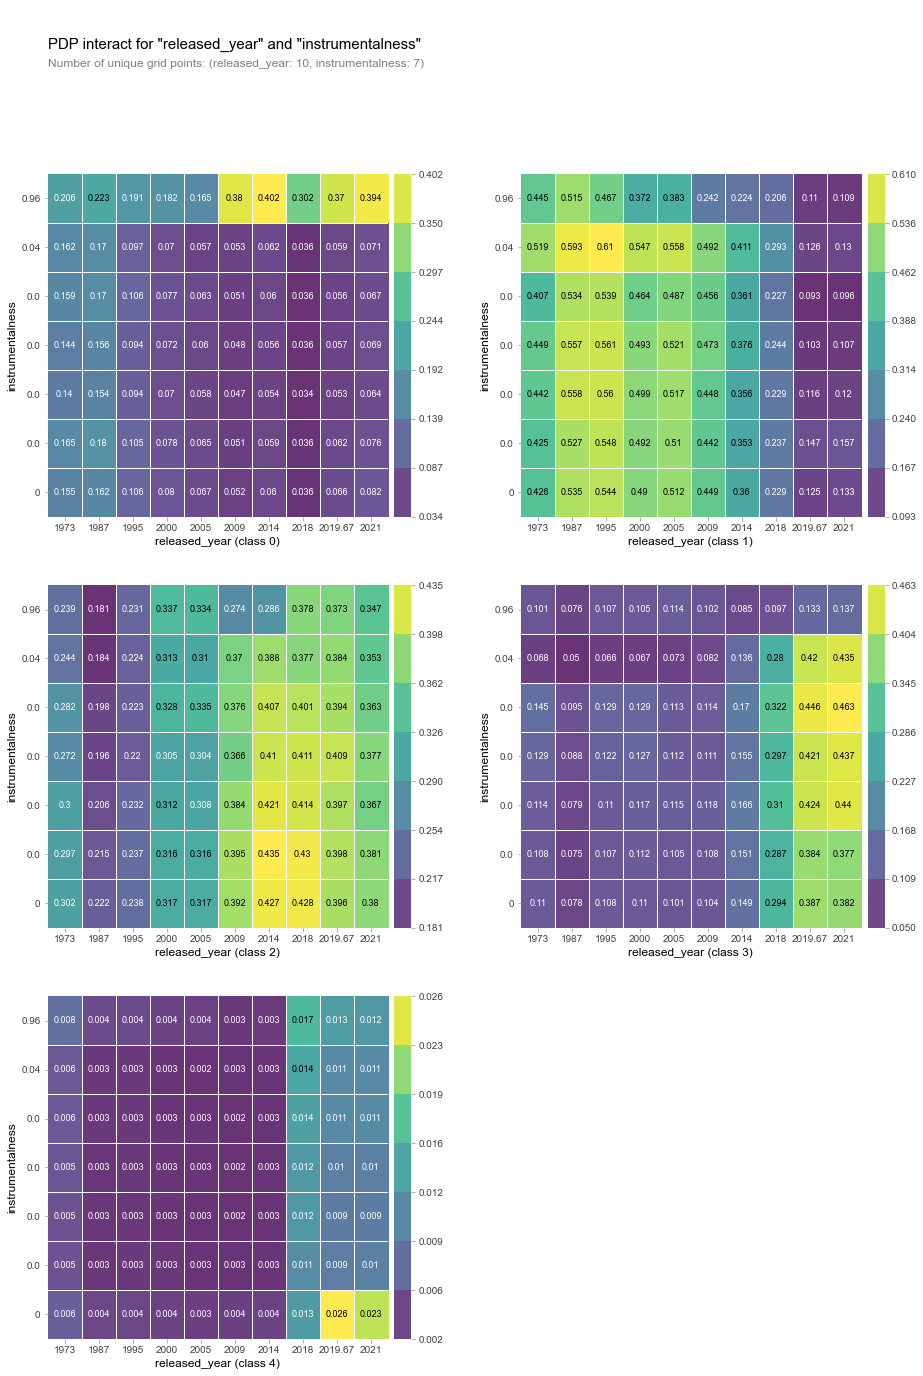

In [34]:
# Make a partial dependecy plot for the top 2 features

# Store the features in an appropriate variable
features = ['released_year', 'instrumentalness']
# Instantiate pdp_interact
interact = pdp_interact(
    model_xgb,
    dataset=X_val,
    model_features=X_val.columns,
    features=features
)

# Plot
pdp_interact_plot(interact, plot_type='grid', feature_names=features)

In [ ]:
# Make a Shaply force plot

# Select an observation
row = X_val.head(1)

explainer = shap.TreeExplainer(####) #Since I'm not to use a pipeline here, I'll have to preprocess the data sets and make a new model to go here.
shap_values = explainer.shap_values(row)

shap.initjs()
shap.force_plot(
    base_value=explainer.expected_value,
    shap_values=shap_values,
    features=row
)